### Feature selection using TNoM score

As a bootstrap is used we set a seed to ensure reproducibility of this reproduce work. We follow the steps in section 4 of the paper and it may take some time to run the bootstrap. We select genes with TNoM score less than 14 and also have bootstrap p-value less than 0.01.

In [1]:
load("DP.rda")
library(ggplot2)
library(ggcorrplot)
set.seed(201703)

In [2]:
# TNoM score
r_score = function(slabel){
    total = length(slabel)
    n = sum(slabel == 0) 
    p = sum(slabel == 1) 
    temp = min(n, p)
    d = ifelse(n < p, 1, -1)
    for(i in 1:(total-1)){
        count = sum(slabel[1:i] == 0)
        t_t = min(n-2*count+i, p+2*count-i)
        t_d = ifelse((n-2*count+i)<(p+2*count-i),1,-1)
        if(t_t < temp){
            temp = t_t
            d = t_d
        }
    }
    c(temp, t_d)
}

# Significance (using bootstrap with size 1000 to replace)
r_bootstrap = function(gene, label){
    total = length(label)
    index = order(gene)
    s_l = label[index]
    score= r_score(s_l)
    dist_score = numeric(200)
    for(i in 1:200){
        temp = sample(1:total)
        t = r_score(label[temp])
        dist_score[i] = t[1]
    }
    prob = mean(dist_score<score[1])
    c(score[1], score[2], prob)
}

In [3]:
# perform the caculation, this may take a while since the inevitable loops in above functions
a = apply(golub_train_p, 2, r_bootstrap, label = golub_train_l)

In [4]:
# select informative genes and subset the train and test data
index = (1:7129)[a[1,]<14 & a[3,]<0.01]
b = order(a[1,index])[1:50]

# data subsetting
train_cl = golub_train_p[, index]
test_cl = golub_test_p[, index]
train_paper3 = train_cl[, b]
train_response = golub_train_r
test_paper3 = test_cl[, b]
test_response = golub_test_r
save(train_paper3, train_response, test_paper3, test_response,train_cl, test_cl,file = "../transformed data/paper3.rda")

#### Correlation Plot

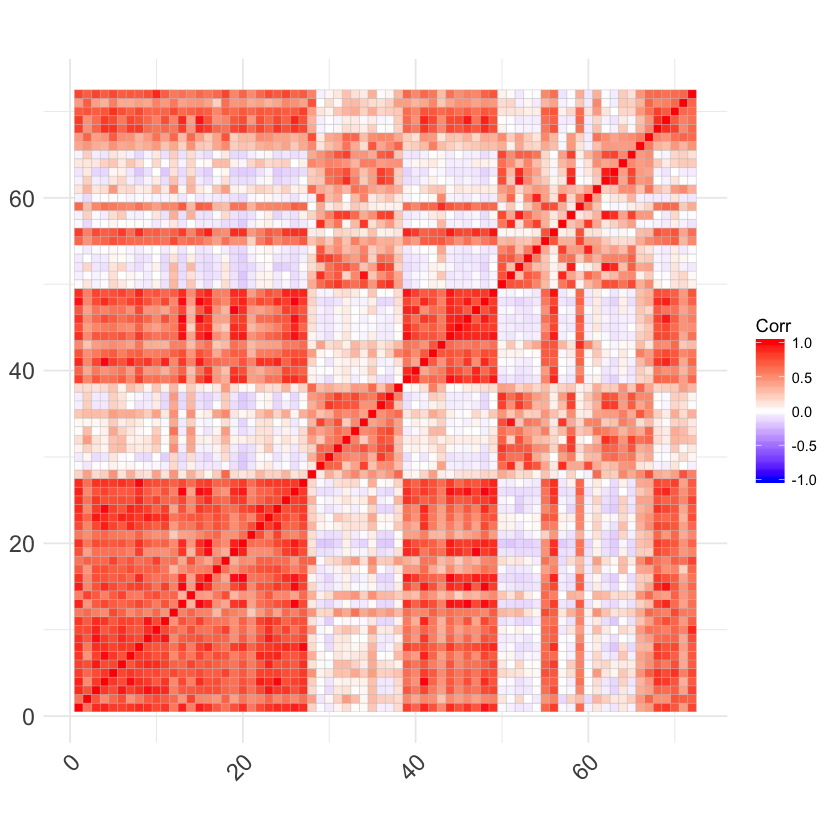

In [5]:
melt_data = rbind(train_paper3, test_paper3)
df_name = c(as.character(train_response), as.character(test_response))
df_id = order(df_name)
melt_data = data.frame(melt_data)
data_corr = cor(t(melt_data[df_id, ]))
ggcorrplot(data_corr,sig.level=0.05, lab_size = 4.5, p.mat = NULL, 
           insig = c("pch", "blank"), pch = 1, pch.col = "black", pch.cex =1,
           tl.cex = 14)